In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cluster import AgglomerativeClustering
import sys
warnings.filterwarnings(action="ignore")

In [3]:
#!pip install --target /content/drive/MyDrive/Colab\ Notebooks/my-modules/ pytorch-lightning

In [4]:
# local, GoogleColab
place = 'GoogleColab'

# path
# GoogleColab
if place == 'GoogleColab':
    path_input = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/input'
    path_submission = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/submission'
    path_preproc_pl = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/notebook/preproc_output/pl'

    sys.path.append('/content/drive/MyDrive/Colab Notebooks/my-modules/')

# local
elif place == 'local':
    path_input = '../input'
    path_submission = '../submission'

In [5]:
station_list = pd.read_csv(f"{path_input}/station_list.csv")
train_data = pd.read_csv(f"{path_input}/train_data.csv")
test_data = pd.read_csv(f"{path_input}/test_data.csv")

print(f'station_list : {station_list.shape}')
print(f'train_data : {train_data.shape}')
print(f'test_data : {test_data.shape}')

station_list : (746, 3)
train_data : (9990, 13)
test_data : (4996, 12)


In [6]:
# idとTargetを分ける
# id
train_id = train_data.id
test_id = test_data.id

# target(評価指標がRMSLEのため、対数化)
train_target = np.log1p(train_data.y)

# df
df_train = train_data.drop(columns=["id", "y"])
df_test = test_data.drop(columns="id")

In [7]:
# shape
print("df_train : ", df_train.shape)
print("df_test : ", df_test.shape)

df_train :  (9990, 11)
df_test :  (4996, 11)


駅をクラスタリング

station_name   longitude   latitude cluster_station
0           白丸  139.114861  35.811735               7
1           古里  139.152102  35.816247               7
2           川井  139.164290  35.813697               7
3           御嶽  139.182589  35.801468               1
4           沢井  139.193324  35.805940               1

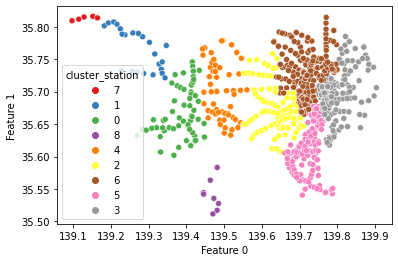

In [8]:
agg = AgglomerativeClustering(n_clusters=9, linkage="complete")
X = station_list[["longitude", "latitude"]]
station_list["cluster_station"] = agg.fit_predict(X).astype(str)
sns.scatterplot(
    x="longitude",
    y="latitude",
    data=station_list,
    hue="cluster_station",
    palette="Set1",
)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
station_list.head()

## 外れ値処理　

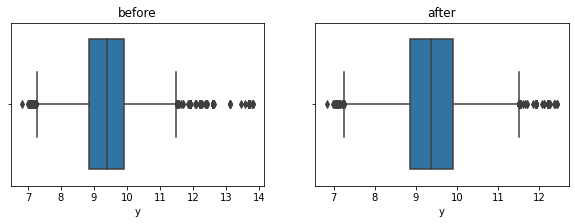

In [9]:
def remove_outlier(x, c):
    """
    x: 数値配列
    c: IQR(四分位範囲のc倍以上を外れ値にする)

    戻り値(idx): bool値の配列。外れ値はFalse。
    """
    iqr = np.quantile(x, 0.75) - np.quantile(x, 0.25)
    idx = np.abs(x - np.median(x)) < c * iqr
    return idx


idx = remove_outlier(train_target, 3)

f, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(train_target, ax=axes[0])
sns.boxplot(train_target[idx], ax=axes[1])
axes[0].set_title("before")
axes[1].set_title("after")
plt.show()

### clipping

In [10]:
def clipping(data):
    p01 = np.quantile(data, 0.01)
    p99 = np.quantile(data, 0.99)

    # 1％点以下の値は1％点に、99％点以上の値は99％点にclippingする
    return np.clip(data, p01, p99)

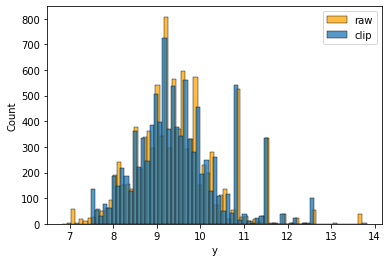

In [11]:
sns.histplot(train_target, color="orange", label="raw")
sns.histplot(clipping(train_target), label="clip")
plt.legend()
plt.show()

## 駅データ

- D＝6378 * arccos{cos(lat1) * cos(lat2) * cos(lon2−lon1) + sin(lat1) * sin(lat2)}
- 2地点の座標は地点1が（緯度=lat1, 経度=lon1)、地点2（緯度=lat2, 経度=lon2)とする

参考：https://blog.shikoan.com/distance-without-for-loop/

In [12]:
def make_distance_list(df1, df2):
    """
    緯度経度データの距離を計算する
    単位：km
    """
    lat1 = np.expand_dims(df1["latitude"].values * np.pi / 180, axis=1)
    lon1 = np.expand_dims(df1["longitude"].values * np.pi / 180, axis=1)
    lat2 = np.expand_dims(df2["latitude"].values * np.pi / 180, axis=0)
    lon2 = np.expand_dims(df2["longitude"].values * np.pi / 180, axis=0)

    distance_list = 6378.137 * np.arccos(
        np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1) + np.sin(lat1) * np.sin(lat2)
    )

    return distance_list

## 自然言語処理

In [13]:
from janome.analyzer import Analyzer
from janome.charfilter import UnicodeNormalizeCharFilter
from janome.tokenfilter import *
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def janome_ploc(text_list):
    # janome
    tokenizer = Tokenizer()
    char_filters = [
        UnicodeNormalizeCharFilter(),
    ]
    token_filters = [
        # CompoundNounFilter(),
        POSStopFilter(["助詞", "助動詞", "記号"]),
        LowerCaseFilter(),
        ExtractAttributeFilter("surface"),
    ]
    a = Analyzer(
        tokenizer=tokenizer, char_filters=char_filters, token_filters=token_filters,
    )

    text_list_janome = [" ".join(a.analyze(text)) for text in text_list]

    return text_list_janome

In [14]:
all_name = janome_ploc(pd.concat([df_train.name, df_test.name]))

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

vectorizer = make_pipeline(
    TfidfVectorizer(),
    make_union(
        TruncatedSVD(n_components=600, random_state=0),
        NMF(n_components=64, random_state=0),
        n_jobs=-1,
        ),
    )
vectorizer.fit(all_name)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('featureunion',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('truncatedsvd',
                                                 TruncatedSVD(n_components=600,
                                                              random_state=0)),
                                                ('nmf',
                                                 NMF(n_components=64,
                                                     random_state=0))]))])

In [16]:
len(vectorizer['tfidfvectorizer'].get_feature_names())

6361

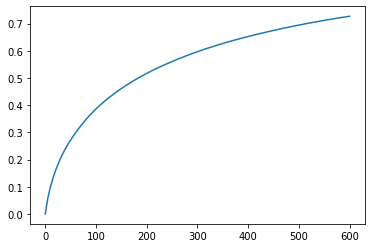

In [17]:
ts = vectorizer['featureunion'].transformer_list[0][1]
ev_ratio = ts.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.plot(ev_ratio)
plt.show()

In [18]:
def col_proc(df):
    """
    引数　：df
    戻り値：num_col, obj_col, dt_col, bool_col

    データの型ごとにDataFrameの列を仕分ける
    ・数値列（num_col） ：number
    ・文字列（obj_col） ：object
    ・日付列（dt_col）  ：datetime
    ・bool列（bool_col）：bool
    """

    num_col = df.select_dtypes(include="number").columns
    obj_col = df.select_dtypes(include=object).columns
    dt_col = df.select_dtypes(include="datetime").columns
    bool_col = df.select_dtypes(include=bool).columns
    if df.shape[1] != len(num_col) + len(obj_col) + len(dt_col) + len(bool_col):
        raise Exception("想定していないデータ型が存在します。")

    for c, name in zip(
        [num_col, obj_col, dt_col, bool_col], ["数値列", "文字列", "日付列", "bool列"]
    ):
        print("-", name)
        if len(c) == 0:
            print("No Exist\n")
        else:
            print(df[c].dtypes.value_counts(), "\n")


    return num_col, obj_col, dt_col, bool_col

### 前処理

In [19]:
import datetime
def progress(message):
    print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} {message}")

In [20]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer


class pre:
    def __init__(self, n_comp=32, nlp_col="name"):
        self.nlp_col = nlp_col
        self.n_comp = n_comp

    def proc(self, df, trainflag):
        self.trainflag = trainflag
        df_tmp = df.copy()

        progress("host_id")
        # host_idをCountEncoding
        if self.trainflag:
            self.ce_ce = ce.CountEncoder()
            self.ce_ce.fit(pd.concat([df_train, df_test])['host_id'].astype(str))
        df_tmp['host_id'] = self.ce_ce.transform(df_tmp['host_id'].astype(str))

        progress("minimum_nights")
        df_tmp['minimum_nights'] = df_tmp['minimum_nights'].astype(str)

        progress("review関連")
        # 欠損値補完（last_review reviews_per_month）
        # レビュー欠損行にフラグ付け
        df_tmp['no_review'] = df_tmp[['last_review','reviews_per_month']].isnull().sum(axis=1) / 2
        # 0補完
        df_tmp[['last_review','reviews_per_month']] = df_tmp[['last_review','reviews_per_month']].fillna(0)
        # last_review列をyear, month, dateに変換
        df_tmp["last_review_year"] = pd.to_datetime(df_tmp["last_review"]).dt.year
        df_tmp["last_review_month"] = pd.to_datetime(df_tmp["last_review"]).dt.month
        df_tmp["last_review_day"] = pd.to_datetime(df_tmp["last_review"]).dt.day
        # last_reviewが2020-05-01から何日前か(train testともに2020-05より前のデータのため)
        df_tmp["last_review_num_days"] = (
            pd.to_datetime("2020-05-01") - pd.to_datetime(df_tmp.last_review)
        ).dt.days
        df_tmp = df_tmp.drop(columns="last_review")

        progress("駅情報")
        # 物件と各駅との距離のリストの作成
        distance_list = make_distance_list(df_tmp, station_list)

        # 最寄り駅と最寄り駅までの距離、2km圏内の駅数の列を追加
        df_tmp["nearest_station"] = [
            station_list["station_name"][i] for i in np.argmin(distance_list, axis=1)
        ]
        df_tmp["distance_nearest_station"] = np.min(distance_list, axis=1)
        df_tmp["number_stations"] = (distance_list < 2).sum(axis=1)
        # 最寄り駅までの距離をカテゴリ化 徒歩5分：0.3~0.4kmのため、0.3km区切り
        bin_edges = [-float("inf"), 0.3, 0.6, 0.9, 1.2, float("inf")]  # binningの範囲
        df_tmp["category_distance_nearest_station"] = pd.cut(
            df_tmp["distance_nearest_station"], bin_edges, labels=False
        )
        # 最寄り駅のクラスタ
        df_tmp["cluster_nearest_station"] = [
            station_list["cluster_station"][i] for i in np.argmin(distance_list, axis=1)
        ]

        progress("name列")
        # 重要そうな単語を洗い出し、含まれているかを0,1で表現する列の追加
        word_list = [
            "uhome",
            "prem|premium",
            "biggest",
            "luxurious|luxury",
            "suite",
            "direct",
            "playroom",
            "美式大床",
            "sky",
            "王",
            "dormitory",
            "semi",
            "☆|♪|★",
            "wifi|wi-fi|wi fi",
            "cozy",
            "hoyo"
        ]
        for word in word_list:
            df_tmp[f"name_{word}"] = (
                df_tmp.name.str.lower().str.contains(word).astype(int)
            )

        progress("NLP")
        # 自然言語処理
        df_tmp = self.nlp(df_tmp)

        # Name列削除
        df_tmp = df_tmp.drop(columns=["name", "latitude", "longitude"])

        progress("OneHotEncode")
        # OneHotEncode
        if self.trainflag:
            # カラム整理
            progress("col_proc")
            _, self.obj_col, _, _ = col_proc(df_tmp)
            print('オブジェクト列：', list(self.obj_col))

            # 序数をカテゴリに付与
            self.ce_ohe = ce.OneHotEncoder(cols=self.obj_col, handle_unknown="value")
            self.ce_ohe.fit(df_tmp)

        df_tmp = self.ce_ohe.transform(df_tmp)

        # progress("StandardScaler")
        # StandardScaler
        progress('RankGauss')
        if self.trainflag:
            # self.sc = StandardScaler()
            # self.sc.fit(df_tmp)
            self.qt = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
            self.qt.fit(df_tmp)

        # df_tmp = pd.DataFrame(self.sc.transform(df_tmp), columns=df_tmp.columns, index=df_tmp.index)        
        df_tmp = pd.DataFrame(self.qt.transform(df_tmp), columns=df_tmp.columns, index=df_tmp.index)  

        progress("done")
        print('\nshape: ', df_tmp.shape)
        print('欠損値数：', df_tmp.isnull().sum().sum())

        return df_tmp

    def nlp(self, df):
        df_tmp = df.copy()

        progress("janome")
        jp_data = janome_ploc(df_tmp[self.nlp_col])

        progress("tfidf & decomposition transform")
        nlp_data = vectorizer.transform(jp_data).astype(np.float32)
        cols = [
                f"{self.nlp_col}_tfidf_svd_{i}"
                for i in range(vectorizer['featureunion'].transformer_list[0][1].n_components)
                ]
        cols += [
                 f"{self.nlp_col}_tfidf_nmf_{i}"
                 for i in range(vectorizer['featureunion'].transformer_list[1][1].n_components)
                 ]
        df_tmp = pd.concat(
            [df_tmp, pd.DataFrame(nlp_data, columns=cols, index=df_tmp.index)], axis=1,
        )

        return df_tmp


In [21]:
# 外れ値処理
idx = remove_outlier(train_target, 3)

df_train_ro = df_train[idx]
train_target_pp = train_target[idx]

# 前処理
pre = pre()
train_features = pre.proc(df_train_ro, True)

# # clipping
# train_target_pp = clipping(train_target)

# # 前処理
# pre = pre()
# train_features = pre.proc(df_train, True)

2022-05-01 17:39:06 host_id
2022-05-01 17:39:06 minimum_nights
2022-05-01 17:39:06 review関連
2022-05-01 17:39:06 駅情報
2022-05-01 17:39:06 name列
2022-05-01 17:39:06 NLP
2022-05-01 17:39:06 janome
2022-05-01 17:39:16 tfidf & decomposition transform
2022-05-01 17:39:17 OneHotEncode
2022-05-01 17:39:17 col_proc
- 数値列
float32    664
int64       25
float64      3
dtype: int64 

- 文字列
object    5
dtype: int64 

- 日付列
No Exist

- bool列
No Exist

オブジェクト列： ['neighbourhood', 'room_type', 'minimum_nights', 'nearest_station', 'cluster_nearest_station']
2022-05-01 17:39:17 RankGauss
2022-05-01 17:39:20 done

shape:  (9889, 1161)
欠損値数： 0


In [22]:
train_features

host_id  neighbourhood_1  neighbourhood_2  neighbourhood_3  \
0    -1.120205         5.199338        -5.199338        -5.199338   
1    -0.816627        -5.199338         5.199338        -5.199338   
2    -5.199338        -5.199338        -5.199338         5.199338   
3     0.321971        -5.199338        -5.199338        -5.199338   
4    -5.199338        -5.199338        -5.199338        -5.199338   
...        ...              ...              ...              ...   
9985  0.472789        -5.199338        -5.199338        -5.199338   
9986  0.389414        -5.199338         5.199338        -5.199338   
9987  0.165327        -5.199338         5.199338        -5.199338   
9988 -0.152506        -5.199338        -5.199338         5.199338   
9989 -0.619855        -5.199338        -5.199338        -5.199338   

      neighbourhood_4  neighbourhood_5  neighbourhood_6  neighbourhood_7  \
0           -5.199338        -5.199338        -5.199338        -5.199338   
1           -5.199338        -5.199338        -5.199338        -5.199338   
2           -5.199338        -5.199338        -5.199338        -5.199338   
3            5.199338        -5.199338        -5.199338        -5.199338   
4           -5.199338         5.199338        -5.199338        -5.199338   
...               ...              ...              ...              ...   
9985        -5.199338         5.199338        -5.199338        -5.199338   
9986        -5.199338        -5.199338        -5.199338        -5.199338   
9987        -5.199338        -5.199338        -5.199338        -5.199338   
9988        -5.199338        -5.199338        -5.199338        -5.199338   
9989        -5.199338        -5.199338        -5.199338        -5.199338   

      neighbourhood_8  neighbourhood_9  ...  name_tfidf_nmf_54  \
0           -5.199338        -5.199338  ...          -5.199338   
1           -5.199338        -5.199338  ...          -5.199338   
2           -5.199338        -5.199338  ...          -5.199338   
3           -5.199338        -5.199338  ...          -5.199338   
4           -5.199338        -5.199338  ...          -5.199338   
...               ...              ...  ...                ...   
9985        -5.199338        -5.199338  ...          -5.199338   
9986        -5.199338        -5.199338  ...           1.720801   
9987        -5.199338        -5.199338  ...           1.730768   
9988        -5.199338        -5.199338  ...          -5.199338   
9989        -5.199338        -5.199338  ...          -5.199338   

      name_tfidf_nmf_55  name_tfidf_nmf_56  name_tfidf_nmf_57  \
0             -5.199338          -5.199338          -5.199338   
1             -5.199338          -5.199338          -5.199338   
2             -5.199338          -5.199338          -5.199338   
3             -5.199338          -5.199338          -5.199338   
4             -5.199338          -5.199338          -5.199338   
...                 ...                ...                ...   
9985          -5.199338           2.042773          -5.199338   
9986          -5.199338          -5.199338          -5.199338   
9987          -5.199338          -5.199338          -5.199338   
9988          -5.199338          -5.199338          -5.199338   
9989          -5.199338           1.811262          -5.199338   

      name_tfidf_nmf_58  name_tfidf_nmf_59  name_tfidf_nmf_60  \
0             -5.199338          -5.199338           2.344246   
1             -5.199338          -5.199338          -5.199338   
2              1.023236           1.074739          -5.199338   
3             -5.199338          -5.199338          -5.199338   
4             -5.199338          -5.199338          -5.199338   
...                 ...                ...                ...   
9985          -5.199338          -5.199338          -5.199338   
9986           1.064620          -5.199338          -5.199338   
9987           1.175817          -5.199338          -5.199338   
9988          -5.199338          -5.19933

In [23]:
test_features = pre.proc(df_test, False)

2022-05-01 17:39:20 host_id
2022-05-01 17:39:20 minimum_nights
2022-05-01 17:39:20 review関連
2022-05-01 17:39:20 駅情報
2022-05-01 17:39:20 name列
2022-05-01 17:39:21 NLP
2022-05-01 17:39:21 janome
2022-05-01 17:39:25 tfidf & decomposition transform
2022-05-01 17:39:26 OneHotEncode
2022-05-01 17:39:26 RankGauss
2022-05-01 17:39:27 done

shape:  (4996, 1161)
欠損値数： 0


In [24]:
test_features

host_id  neighbourhood_1  neighbourhood_2  neighbourhood_3  \
0     0.321971        -5.199338        -5.199338        -5.199338   
1    -5.199338        -5.199338        -5.199338        -5.199338   
2     0.834427        -5.199338        -5.199338        -5.199338   
3    -0.282216        -5.199338        -5.199338        -5.199338   
4    -0.152506        -5.199338         5.199338        -5.199338   
...        ...              ...              ...              ...   
4991 -0.619855        -5.199338        -5.199338        -5.199338   
4992  0.321971        -5.199338         5.199338        -5.199338   
4993 -0.037988        -5.199338        -5.199338        -5.199338   
4994  0.389414        -5.199338        -5.199338        -5.199338   
4995 -0.282216        -5.199338        -5.199338        -5.199338   

      neighbourhood_4  neighbourhood_5  neighbourhood_6  neighbourhood_7  \
0           -5.199338        -5.199338        -5.199338        -5.199338   
1           -5.199338        -5.199338        -5.199338         5.199338   
2           -5.199338        -5.199338        -5.199338        -5.199338   
3           -5.199338        -5.199338        -5.199338         5.199338   
4           -5.199338        -5.199338        -5.199338        -5.199338   
...               ...              ...              ...              ...   
4991         5.199338        -5.199338        -5.199338        -5.199338   
4992        -5.199338        -5.199338        -5.199338        -5.199338   
4993        -5.199338         5.199338        -5.199338        -5.199338   
4994        -5.199338         5.199338        -5.199338        -5.199338   
4995        -5.199338         5.199338        -5.199338        -5.199338   

      neighbourhood_8  neighbourhood_9  ...  name_tfidf_nmf_54  \
0           -5.199338        -5.199338  ...          -5.199338   
1           -5.199338        -5.199338  ...          -5.199338   
2           -5.199338         5.199338  ...          -5.199338   
3           -5.199338        -5.199338  ...          -5.199338   
4           -5.199338        -5.199338  ...          -5.199338   
...               ...              ...  ...                ...   
4991        -5.199338        -5.199338  ...          -5.199338   
4992        -5.199338        -5.199338  ...          -5.199338   
4993        -5.199338        -5.199338  ...          -5.199338   
4994        -5.199338        -5.199338  ...          -5.199338   
4995        -5.199338        -5.199338  ...          -5.199338   

      name_tfidf_nmf_55  name_tfidf_nmf_56  name_tfidf_nmf_57  \
0              1.133311          -5.199338          -5.199338   
1              1.215508          -5.199338          -5.199338   
2             -5.199338          -5.199338           1.038553   
3             -5.199338          -5.199338          -5.199338   
4             -5.199338          -5.199338           1.647449   
...                 ...                ...                ...   
4991          -5.199338          -5.199338          -5.199338   
4992          -5.199338          -5.199338          -5.199338   
4993          -5.199338          -5.199338          -5.199338   
4994          -5.199338          -5.199338          -5.199338   
4995          -5.199338          -5.199338           0.896857   

      name_tfidf_nmf_58  name_tfidf_nmf_59  name_tfidf_nmf_60  \
0              1.679208           2.244676          -5.199338   
1              1.746224           1.115555          -5.199338   
2             -5.199338          -5.199338           1.352827   
3             -5.199338          -5.199338           1.166139   
4             -5.199338          -5.199338           1.764220   
...                 ...                ...                ...   
4991          -5.199338           1.181694          -5.199338   
4992          -5.199338          -5.199338          -5.199338   
4993           1.011759          -5.199338           1.431358   
4994          -5.199338          -5.19933

## pickleに保存

In [25]:
# path
train_features_path = f"{path_preproc_pl}/train_features.pickle"
test_features_path = f"{path_preproc_pl}/test_features.pickle"
train_target_pp_path = f"{path_preproc_pl}/train_target.pickle"
test_id_path = f"{path_preproc_pl}/test_id_path.pickle"

In [26]:
from pathlib import Path
for path in [train_features_path, test_features_path, train_target_pp_path, test_id_path]:
    myfile = Path(path)
    myfile.touch(exist_ok=True)

In [27]:
with open(train_features_path, 'wb') as p:
    pickle.dump(train_features, p)

with open(test_features_path, 'wb') as p:
    pickle.dump(test_features, p)

with open(train_target_pp_path, 'wb') as p:
    pickle.dump(train_target_pp, p)

with open(test_id_path, 'wb') as p:
    pickle.dump(test_id, p)